<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sprintの目的**

スクラッチを通してニューラルネットワークの発展的内容を理解する

**どのように学ぶか**

スクラッチで作成したニューラルネットワークの実装を拡張していきます。

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データ
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割(訓練データ・評価データ)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

11501568/11490434 [==============================] - 0s 0us/step


# 2.ディープニューラルネットワークスクラッチ

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

**層などのクラス化**

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


***手を加える箇所***


層の数
層の種類（今後畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

《サンプルコード1》


ScratchDeepNeuralNetrowkClassifierのfitメソッド内




In [3]:
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()

NameError: ignored

《サンプルコード2》


イテレーションごとのフォワード

In [ ]:
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)

《サンプルコード3》


イテレーションごとのバックワード



In [ ]:
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

**【問題1】全結合層のクラス化**

全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、すべて全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。


《雛形》

In [3]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        """
        コンストラクタ
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        initializer : 初期化方法のインスタンス
        optimizer : 最適化手法のインスタンス
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化インスタンスの関数実行
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        # 最適化インスタンス
        self.optimizer = optimizer
        # 勾配更新の際に使用(AdaGradのみ)
        self.HW = 0
        self.HB = 0
  
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        # 逆伝播時に使用
        self.Z = X
        # 順伝播計算部分本体
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        """
        dA : 前の層から逆伝播してきた値（活性化関数の逆伝播の値が入ってくる）
        
        Overview
        ----------
        前回のSprint9 ニューラルネットワークでは下記のような逆伝播処理になっていた
            0 ## 2層目
            1 dZ2 = dA3 @ self.W3.T
            2 dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
            3 dW2 = self.Z1.T @ dA2
            4 dB2 = np.sum(dA2, axis=0)
            5 ## 1層目
            6 dZ1 = dA2 @ self.W2.T
            7 dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
            8 dW1 = X.T @ dA1
            9 dB1 = np.sum(dA1, axis=0)
        勾配の計算
            ここでは、活性化関数の逆伝播は別で実装し、その値をこの関数の引数として受け取っているので、
            この関数の  dA  は、Sprint9の上記の  dA2  に該当する
            よって、上記3,4に該当する処理を書いていけばいい
        逆伝播の値の計算
            活性化関数の逆伝播に渡してやる値、つまりSprint9の上記の  dZ1  に該当する
        重み更新
            勾配dB,dWが計算されているので、このインスタンス自身をoptimizerインスタンスのupdate関数に渡してやる
            optimizerインスタンスのupdate関数の引数は、layerとなっているので、update関数内では、layer.変数名で
            このインスタンスの各種メンバ変数にアクセスできる
        """
        # バイアス項の勾配
        self.dB = np.sum(dA, axis=0)
        # バイアス項以外の勾配
        self.dW = self.Z.T @ dA
        # 逆伝播させる値
        self.dZ = dA @ self.W.T
        # 重み更新
        self = self.optimizer.update(self)
        return self.dZ

**【問題2】初期化方法のクラス化**

初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。
《雛形》

In [4]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    """
    def __init__(self, sigma):
        """
        コンストラクタ
        Parameters
        ------------
        sigma : 
        　　　　重みの初期化の際のガウス分布の標準偏差
        """
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        コンストラクタ
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        コンストラクタ
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

**【問題3】最適化手法のクラス化**

最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [5]:
# 雛形
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Overview
        FCクラス内のbackward関数内で下記の要に実行されている
            0 self.optimizer.update(self)
        引数に「FCクラスのインスタンス自身」が入っていることを考えると
        layer.dW , layer.dB , layer.Z は「FCクラスのインスタンスのメンバ変数」にアクセスしていると考えられる              
        """
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer

**【問題4】活性化関数のクラス化**

活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。



In [6]:
class Sigmoid:
    """シグモイド関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

In [7]:
class Tanh:
    """tanh関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

In [8]:
class Softmax:
    """Softmax関数"""
    def forward(self, A): 
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        """逆伝播
        Parameters
        ----------
        Z : 出力値
        y : 正解データ
        """
        # 逆伝播の値
        dA = Z - y
        # 損失
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

**発展的要素**

活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

**【問題5】ReLUクラスの作成**

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [9]:
class ReLU:
    """ReLU関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

**【問題6】重みの初期値**

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

**Xavierの初期値**

Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。
$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数


《論文》


Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.

Heの初期値

Heの初期値における標準偏差 $\sigma$ は次の式で求められます。
$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数


《論文》


He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.

In [10]:
class XavierInitializer:
    """Xavierの初期化クラス"""
    def __init__(self, sigma):
        """コンストラクタ
        Parameters
        ----------
        sigma : 使用されていない
        
        Overview
        ----------
        なぜ使用されていないのに、引数として受け取っているのか
        
        初期化クラスは、概略すると、下記のように使用されている
        
        呼び出しの大元
            dnn = ScratchDeepNeuralNetrowkClassifier(initializer=SGD or XavierInitializer or HeInitializer) 
            
        定義部分(ScratchDeepNeuralNetrowkClassifier)
            class ScratchDeepNeuralNetrowkClassifier:
                def __init__(self,xxx,xxx,xxx,initializer):
                    .....
                    self.initializer = initializer
                    .....
                def fit(self,xxx,xxx,xxx):
                    self.initializer(self.sigma)
        
        つまり、
        「呼び出しの大元」で、どの初期化クラスが渡されるかわからないので、
        初期化クラスによっては、sigmaが必要なものと、別途計算が必要なものがあるので、
        同じ呼び出し方をしてやるために、この初期かクラスのコンストラクタでも引数として、sigmaを受け取っている
        
        同じ呼び出し方をしてやらないのであれば、上記fitは、下記のような書き方でも可能
            if initializerのクラス名 == "SGD":
                self.initializer(self.sigma)
            else initializerのクラス名 != "SGD":
                self.initializer()
        """
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [11]:
class HeInitializer:
    """Heの初期化クラス"""
    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

**【問題7】最適化手法**

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha \frac{\partial L}{\partial W_i} \\
B_i^{\prime} = B_i - \alpha \frac{\partial L}{\partial B_i}
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的にはすべて同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。


$$
H_i^{\prime} = H_i + \frac{\partial L}{\partial W_i} \odot \frac{\partial L}{\partial W_i} \\
W_i^{\prime} = W_i - \alpha \left( \frac{1}{\sqrt{H_i^{\prime}}} \odot \frac{\partial L}{\partial W_i} \right)
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$


《論文》


Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).

In [12]:
class AdaGrad:
    """最適化手法（AdaGrad）"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr 
    
    def update(self, layer):
        """コンストラクタ
        Parameters
        ----------
        layer : layerインスタンス
        """
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 # 0割エラー防止のため
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

**【問題8】クラスの完成**

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [13]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """通常のコンストラクタと同様の働き
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.005,epoch=10,sigma=0.02,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True):
        """コンストラクタ
        Parameters
        ----------
        batch_size : バッチサイズ（default:20)
        n_features : 説明変数の数（default:784)
        n_nodes1 : 前の層のノード数（default:400)
        n_nodes2 : 当該層のノード数（default:200)
        n_output : 出力層のノード数（default:10)
        sigma : 初期化時のパラメータ（default:0.02)
        lr : 学習率（default:0.005)
        verbose : 計算過程の出力（default:True)
        epoch : 学習回数（default:10)
        optimizer : 最適化手法（default:SGD)
        initializer : 初期化方法（default:HeInitializer）
        activater : 活性化関数（default:ReLU）
        """
        self.batch_size = batch_size
        self.n_features = n_features 
        self.n_nodes1 = n_nodes1  
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.lr = lr
        self.epoch = epoch
        self.optimizer = optimizer 
        self.sigma = sigma
        self.initializer = initializer 
        self.activater = activater
        self.output_activater = output_activater 
        self.verbose = verbose
    
    def fit(self, X, y, X_val=None, y_val=None):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # lossの記録用配列
        self.loss_train = [] 
        self.loss_val = [] 
        # 最適化手法の初期化
        optimizer = self.optimizer(self.lr)
        # 各層の初期化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = self.output_activater()
        
        # 学習回数分ループ
        for i in range(self.epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            # ミニバッチイテレータループ
            for mini_X, mini_y in get_mini_batch:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                ## 逆伝播
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
            # 過程出力
            if self.verbose:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)      
                # 損失計算と記録
                loss = self.activation3.backward(Z3, y)[1]
                self.loss_train.append(loss)
                print('epoch:%d train_loss:%f'%(i,loss))
                # 評価データ見る
                if X_val is not None:
                    ## 順伝播
                    # 1層目
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    # 2層目
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    # 3層目
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    # 損失計算と記録
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])
    
    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 入力配列
        """
        ## 順伝播
        # 1層目
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        # 2層目
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        # 3層目
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        # 最も大きいインデックスを採用
        return np.argmax(Z3, axis=1)

# 3.検証


**【問題9】学習と推定**

層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [15]:
dnn = ScratchDeepNeuralNetrowkClassifier(epoch=100) 

dnn.fit(X_train[:4000], y_train_one_hot[:4000], X_val[:2000], y_test_one_hot[:2000])

epoch:0 train_loss:1.355044
epoch:1 train_loss:0.833435
epoch:2 train_loss:0.617198
epoch:3 train_loss:0.505132
epoch:4 train_loss:0.440820
epoch:5 train_loss:0.398909
epoch:6 train_loss:0.368104
epoch:7 train_loss:0.338458
epoch:8 train_loss:0.318811
epoch:9 train_loss:0.301731
epoch:10 train_loss:0.286110
epoch:11 train_loss:0.275386
epoch:12 train_loss:0.265225
epoch:13 train_loss:0.257080
epoch:14 train_loss:0.241316
epoch:15 train_loss:0.232369
epoch:16 train_loss:0.225370
epoch:17 train_loss:0.217288
epoch:18 train_loss:0.209554
epoch:19 train_loss:0.202682
epoch:20 train_loss:0.198153
epoch:21 train_loss:0.189635
epoch:22 train_loss:0.186034
epoch:23 train_loss:0.179473
epoch:24 train_loss:0.175927
epoch:25 train_loss:0.167212
epoch:26 train_loss:0.162480
epoch:27 train_loss:0.158116
epoch:28 train_loss:0.152473
epoch:29 train_loss:0.149652
epoch:30 train_loss:0.146539
epoch:31 train_loss:0.142614
epoch:32 train_loss:0.137945
epoch:33 train_loss:0.133693
epoch:34 train_loss:0.13

In [16]:
pred = dnn.predict(X_val)
accuracy_score(y_val, pred)

0.9281666666666667

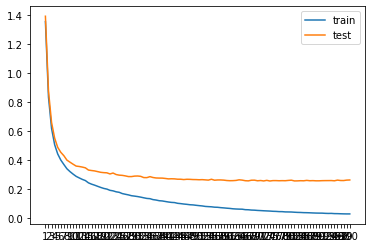

In [17]:
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_train, label='train')
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, dnn.epoch+1)));